Features after VarianceThreshold: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Top 10 Selected Features (after SelectKBest): ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']


Cross-Validation Accuracy Scores: ['69.53%', '73.44%', '71.09%', '76.56%', '81.25%']
Mean CV Accuracy: 74.38%
Standard Deviation: 4.18%
Accuracy: 79.38%
ROC AUC Score: 81.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        80
           1       0.71      0.90      0.80        80

    accuracy                           0.77       160
   macro avg       0.79      0.77      0.76       160
weighted avg       0.79      0.77      0.76       160


Predictions saved to predictions.csv

Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.5
0    0.5
Name: propo

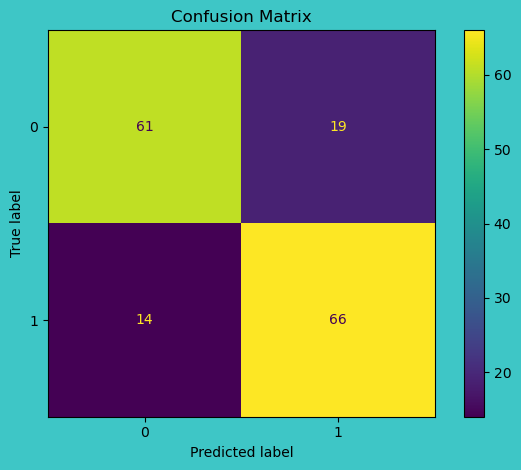

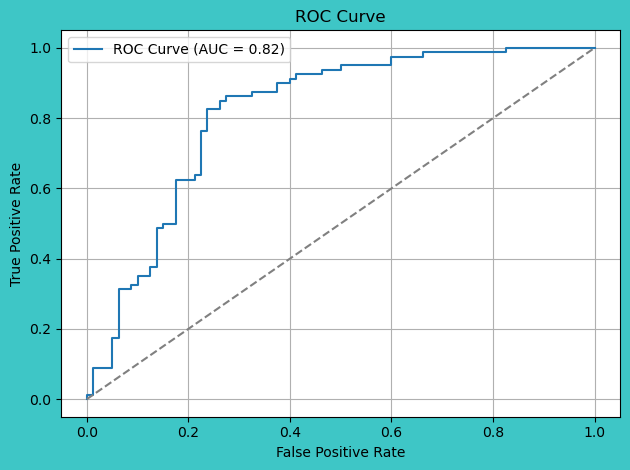

In [25]:
#LR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
# shap library import removed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia logic
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Feature selection
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

X = data_scaled
y = data['Heartdisease']

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

# Get feature names after VarianceThreshold
features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
# Convert X_train_var and X_test_var back to DataFrame with correct column names
X_train_var_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_var_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)


# Select top features
selector = SelectKBest(score_func=f_classif, k=min(10, X_train_var_df.shape[1])) # Use df.shape[1]
X_train_selected = selector.fit_transform(X_train_var_df, y_train)
X_test_selected = selector.transform(X_test_var_df)
selected_features = [features_kept[i] for i in selector.get_support(indices=True)]

# Print selected features
print(f"Features after VarianceThreshold: {features_kept}")
print(f"Top {min(10, X_train_var_df.shape[1])} Selected Features (after SelectKBest): {selected_features}\n")

# Convert X_train_selected and X_test_selected back to DataFrame for consistency
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)


# Logistic Regression (no SMOTE)
model = LogisticRegression(max_iter=1000, random_state=42) # Added random_state for reproducibility
model.fit(X_train_selected_df, y_train) # Fit on DataFrame
from sklearn.model_selection import cross_val_score

# --- Cross-Validation Accuracy (Validation Score) ---
cv_scores = cross_val_score(model, X_train_selected_df, y_train, cv=5, scoring='accuracy')

print(f"\nCross-Validation Accuracy Scores: {[f'{score * 100:.2f}%' for score in cv_scores]}")
print(f"Mean CV Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation: {np.std(cv_scores) * 100:.2f}%")


# Predict
predicted_proba = model.predict_proba(X_test_selected_df)[:, 1] # Predict on DataFrame
predicted_proba_percent = predicted_proba * 100
predicted_class = (predicted_proba >= 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))



# Predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Enrich with original features
# Ensure mapping is consistent with original data's encoding
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']


# Save predictions
predictions_df.to_csv('predictions.csv')
print("\nPredictions saved to predictions.csv")


# Class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# SHAP code removed

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected features after SelectKBest: ['RBC', 'Hb', 'MCV', 'RDW-CV', 'BP', 'Diabetes', 'Age', 'Gender']

--- SVC with GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Validation Accuracy Scores (5-fold CV): ['74.22%', '72.66%', '78.12%', '77.34%', '78.12%']
Mean CV Accuracy: 76.09%
Standard Deviation of CV Accuracy: 2.24%

Test Accuracy: 78.12%
Test ROC AUC Score: 82.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        80
           1       0.73      0.89      0.80        80

    accuracy                           0.78       160
   macro avg       0.79      0.78      0.78       160
weighted avg       0.79      0.78      0.78       160

Predictions saved to predictions_svm_tuned_no_

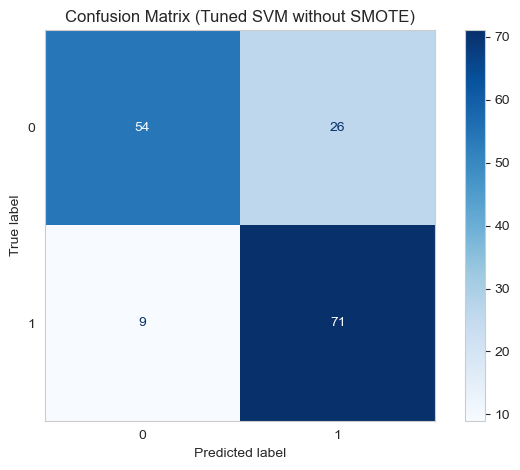

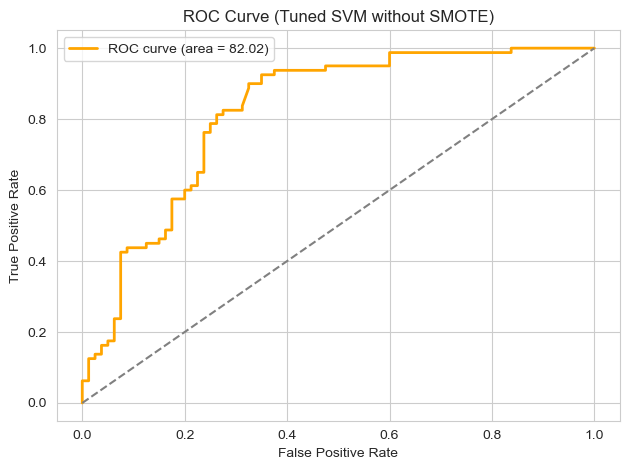

In [11]:
#SVM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=min(8, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)
selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print("Selected features after SelectKBest:", selected_features)

# --- HYPERPARAMETER TUNING FOR SVC ---
print("\n--- SVC with GridSearchCV ---")

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svc = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svc,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_svc.fit(X_train_selected, y_train)

model = grid_search_svc.best_estimator_

# --- Mean CV Accuracy & Std Dev ---
cv_accuracy_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1)
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nValidation Accuracy Scores (5-fold CV): {[f'{score * 100:.2f}%' for score in cv_accuracy_scores]}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation of CV Accuracy: {std_cv_accuracy:.2f}%")

# Predict on test set
predicted_proba = model.predict_proba(X_test_selected)[:, 1]
predicted_proba_percent = predicted_proba * 100
threshold = 0.5
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation on test set (in %)
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"\nTest Accuracy: {accuracy:.2f}%")
print(f"Test ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions enriched with original categorical info
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol']
predictions_df['Diabetes'] = temp_data_for_display['Diabetes']
predictions_df['BP'] = temp_data_for_display['BP']

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_svm_tuned_no_smote.csv')
print("Predictions saved to predictions_svm_tuned_no_smote.csv")

# Summary
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
# Remove custom background color
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot with blue colormap
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)
plt.title("Confusion Matrix (Tuned SVM without SMOTE)")
plt.tight_layout()
plt.show()


# ROC Curve
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned SVM without SMOTE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']

--- Embedded Method (SelectFromModel) with Tuned Decision Tree ---
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters for Embedded Method: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 2, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.7994

Cross-Validation Accuracy Scores: ['71.09%', '63.28%', '81.25%', '74.22%', '76.56%']
Mean CV Accuracy: 73.28%
Standard Deviation: 6.00%
Selected features with Embedded Method: ['RDW-CV', 'Age']
Accuracy: 73.75%
ROC AUC Score: 76.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        80
           1       0.68      0.89      0.77 

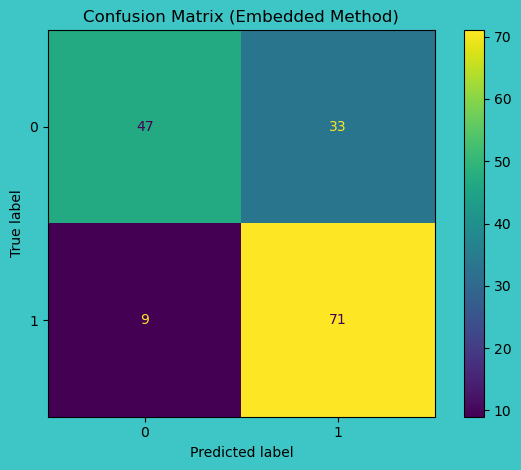

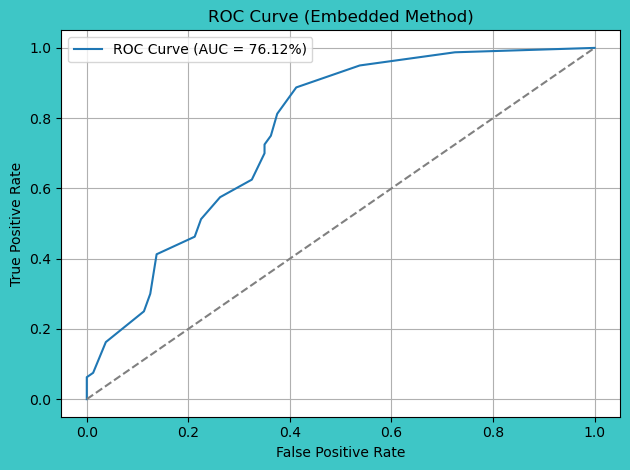

In [9]:
#DT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']

    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:  # age >= 12
        if gender == 0:  # Female
            return hb < 12.0
        elif gender == 1:  # Male
            return hb < 13.0
        else:
            return False  # handle unknown gender

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    # Determine threshold based on age and gender
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0

    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features for modeling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD (SelectFromModel) ---
print("\n--- Embedded Method (SelectFromModel) with Tuned Decision Tree ---")

# Pipeline with RandomForestClassifier for feature importance and DecisionTreeClassifier for final prediction
pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid
param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1], 
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV without SMOTE
grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original training data
grid_search_embedded.fit(X_train_var, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

# --- CROSS-VALIDATION ACCURACY SCORES ---
cv_accuracy_scores = cross_val_score(best_pipeline, X_train_var, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

# Selected features from embedded method
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

# Predict on test set
predicted_proba = best_pipeline.predict_proba(X_test_var)[:, 1]

# Convert probabilities to percentages
predicted_proba_percent = predicted_proba * 100

# Threshold for classification
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Prepare predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Map back Cholesterol, Diabetes, BP for test set
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

# Add Anemia Severity and Anemia labels for display (re-calculated)
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

temp_data_for_display['Anemia_Severity_Display'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
temp_data_for_display['Anemia_Display'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display['Anemia_Severity_Display']
predictions_df['Anemia'] = temp_data_for_display['Anemia_Display']

# Save predictions
predictions_df.to_csv('predictions_dt_embedded.csv')
print("Predictions saved to predictions_dt_embedded.csv")

# Print class distributions
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Embedded Method (SelectFromModel) with Tuned LightGBM ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

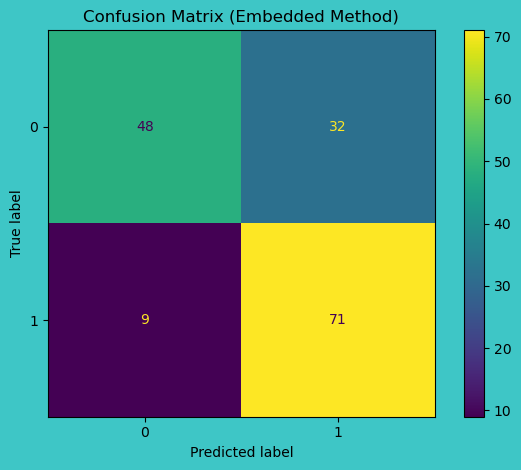

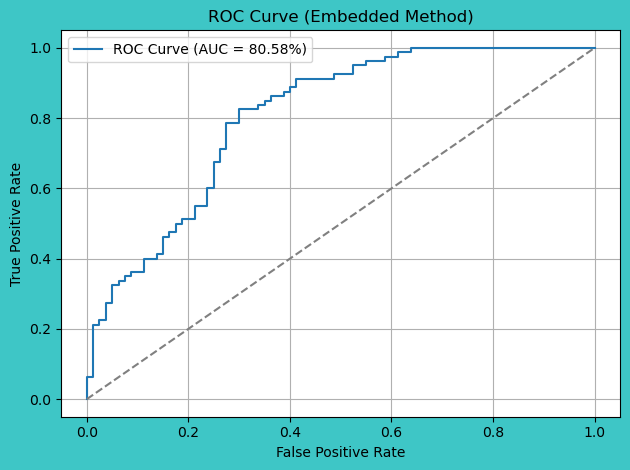

In [15]:
#LightGBM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Embedded method with SelectFromModel and LightGBM ---
print("\n--- Embedded Method (SelectFromModel) with Tuned LightGBM ---")

# Estimator for feature selection
lgbm_selector_estimator = LGBMClassifier(random_state=42, n_estimators=100)
selector_embedded = SelectFromModel(lgbm_selector_estimator, threshold="median")

# Final classifier
classifier_lgbm = LGBMClassifier(random_state=42)

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', selector_embedded),
    ('classifier', classifier_lgbm)
])

# Parameter grid for tuning
param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median'],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__num_leaves': [15, 31],
    'classifier__learning_rate': [0.05, 0.1]
}

# GridSearchCV without SMOTE
grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)
grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

# Cross-validation accuracy scores
cv_accuracy_scores = cross_val_score(best_pipeline, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

# Selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

# Predict on test
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

predictions_df.to_csv('predictions_lightgbm_embedded.csv')
print("Predictions saved to predictions_lightgbm_embedded.csv")

# Class distribution summary
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix plot
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Total dataset size: 800
Missing target values: 0

--- Embedded Method (SelectFromModel) with Tuned Random Forest ---
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters for Embedded Method: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.8106

Cross-Validation Accuracy Scores: ['80.47%', '67.97%', '78.91%', '72.66%', '71.09%']
Mean CV Accuracy: 74.22%
Standard Deviation: 4.74%
Selected features with Embedded Method: ['RDW-CV', 'Age']
Accuracy: 74.38%
ROC AUC Score: 79.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.69        80
           1       0.68      0.93      0.78        80

    accuracy                           0.74       160
   macro avg       0.78      0.74      0.74       160
weig

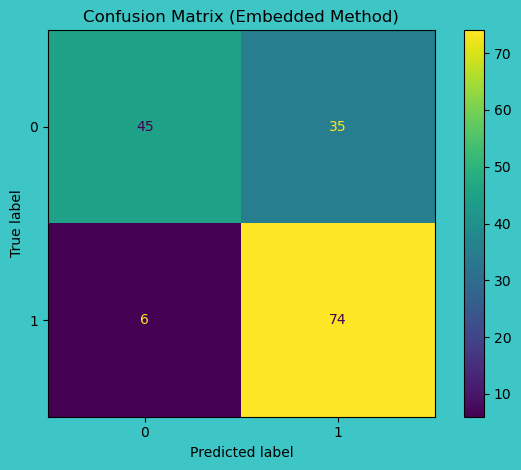

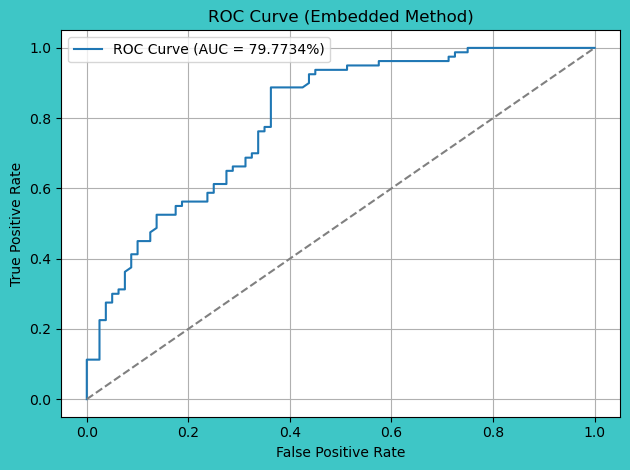

Number of patients with Anemia and Heart Disease: 297


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        if gender == 0:
            return hb < 12.0
        elif gender == 1:
            return hb < 13.0
        else:
            return False

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Embedded method (SelectFromModel) ---
print("\n--- Embedded Method (SelectFromModel) with Tuned Random Forest ---")

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1], 
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original training data without SMOTE
grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

# Cross-validation accuracy scores
cv_accuracy_scores = cross_val_score(best_pipeline, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]
predicted_proba_percent = predicted_proba * 100

threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

# Print accuracy and ROC AUC without rounding (4 decimal places)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_rf_embedded.csv')
print("Predictions saved to predictions_rf_embedded.csv")

print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc * 100:.4f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
count_anemia_and_hd = anemia_and_hd.shape[0]
print(f"Number of patients with Anemia and Heart Disease: {count_anemia_and_hd}")



--- Embedded Method (SelectFromModel) with Tuned XGBoost ---
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for Embedded Method: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.8143

Cross-Validation Accuracy Scores: ['77.34%', '67.97%', '77.34%', '71.88%', '77.34%']
Mean CV Accuracy: 74.38%
Standard Deviation: 3.84%
Selected features with Embedded Method: ['RDW-CV', 'Diabetes', 'Age']
Accuracy: 0.74
ROC AUC Score: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.56      0.68        80
           1       0.68      0.91      0.78        80

    accuracy                           0.74       160
   macro avg       0.77      0.74      0.73       160
weighted avg       0.77      0.74      0.73       160

Predictions saved to predictions_xgboost_embedded.csv

Count of samples by Anemia Severity and Pre

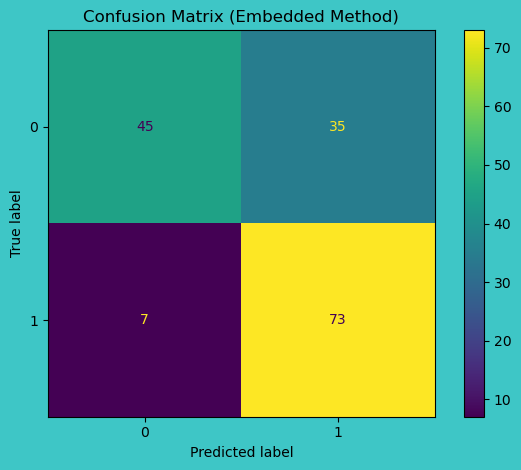

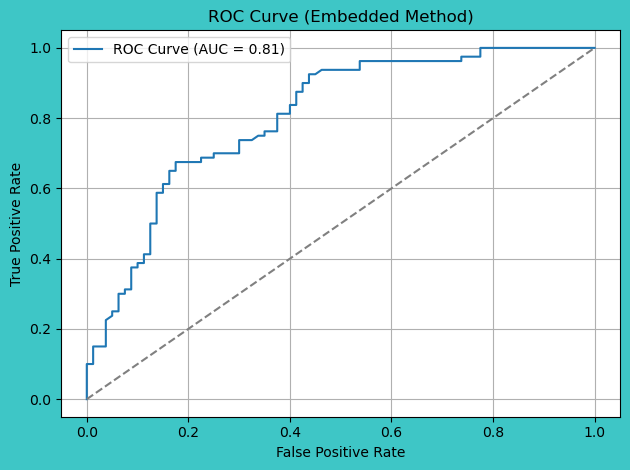

Number of patients with Anemia and Heart Disease: 297


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split (no SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Embedded Feature Selection + XGBoost ---
print("\n--- Embedded Method (SelectFromModel) with Tuned XGBoost ---")

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    )),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.15],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0, 0.1, 0.2]
}

grid_search_embedded = GridSearchCV(
    pipeline_embedded,
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

# Cross-validation accuracy scores
cv_accuracy_scores = cross_val_score(best_pipeline, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

# Predictions
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]
predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

bins = [1, 20, 40, 60, 80, 100]
labels = ['1-20%', '21-40%', '41-60%', '61-80%', '81-100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)
predictions_df.to_csv('predictions_xgboost_embedded.csv')
print("Predictions saved to predictions_xgboost_embedded.csv")

print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Count patients with Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
print(f"Number of patients with Anemia and Heart Disease: {anemia_and_hd.shape[0]}")


Selected Features: ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Tuning Logistic Regression...
Tuning Random Forest...
Tuning SVM...
Tuning LightGBM...
Tuning Decision Tree...
Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params XGBoost: {'subsample': 0.6, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best ROC AUC XGBoost tuning: 0.8056

Cross-Validation Accuracy Scores (Ensemble): [0.7421875 0.6953125 0.7890625 0.765625  0.7578125]
Mean CV Accuracy (Ensemble): 75.00%
Standard Deviation: 3.12%
Best Threshold: 0.46, Best F1 Score: 0.7956

Final Ensemble Model Performance:
Accuracy: 76.88%
ROC AUC Score: 82.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        80
           1       0.71      0.90      0.80        80

    accuracy                           0.77       160
   macro avg       0.7

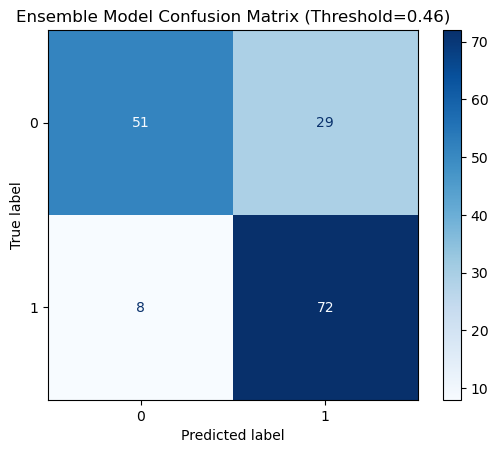

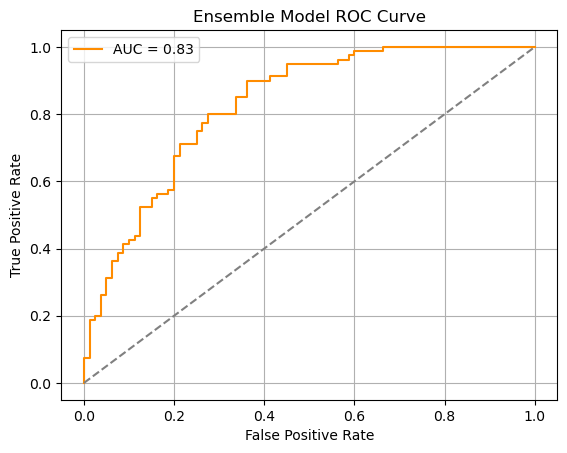

In [5]:
#ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_rf = {'n_estimators': [100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
param_lgbm = {'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
param_dt = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
param_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)
lgbm_search = RandomizedSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_lgbm, cv=3, n_iter=5,
                                 scoring='roc_auc', random_state=42, n_jobs=-1)
dt_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
xgb_search = RandomizedSearchCV(xgb, param_xgb, n_iter=10, scoring='roc_auc', cv=3,
                                verbose=1, random_state=42, n_jobs=-1)

# Fit all tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning Random Forest...")
rf_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

print("Tuning LightGBM...")
lgbm_search.fit(X_train, y_train)

print("Tuning Decision Tree...")
dt_search.fit(X_train, y_train)

print("Tuning XGBoost...")
xgb_search.fit(X_train, y_train)

print(f"Best params XGBoost: {xgb_search.best_params_}")
print(f"Best ROC AUC XGBoost tuning: {xgb_search.best_score_:.4f}")

# Best XGBoost estimator
xgb_model_tuned = xgb_search.best_estimator_

# Build ensemble with all tuned models
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('rf', rf_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
        ('xgb', xgb_model_tuned),
        ('lgbm', lgbm_search.best_estimator_),
        ('dt', dt_search.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Selected Features: ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Tuning Logistic Regression...
Tuning SVM...

Cross-Validation Accuracy Scores (Ensemble): [0.6875    0.7109375 0.7265625 0.75      0.78125  ]
Mean CV Accuracy (Ensemble): 73.12%
Standard Deviation: 3.22%
Best Threshold: 0.49, Best F1 Score: 0.8024

Final Ensemble Model Performance:
Accuracy: 79.38%
ROC AUC Score: 82.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        80
           1       0.77      0.84      0.80        80

    accuracy                           0.79       160
   macro avg       0.80      0.79      0.79       160
weighted avg       0.80      0.79      0.79       160

Predictions saved to 'ensemble2_model_predictions_anemia_optimized.csv'


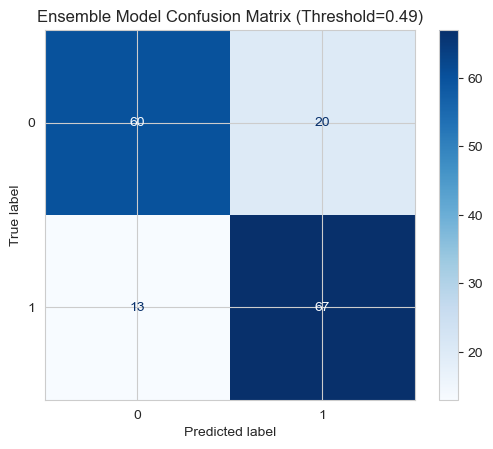

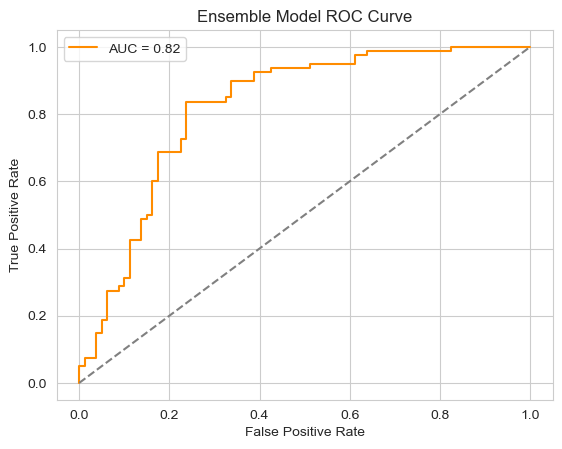

In [13]:
#ensemble 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)

# Fit tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

# Build ensemble with tuned Logistic Regression and SVM
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble1_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble2_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


